In [8]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Load the .csv file
csv_file = 'C:\\Users\\Ashle\\OneDrive\\Desktop\\Lab codes\\2025 data\\carbenoxolone data\\carbenoxolone.csv'

#Read CSV file
data = pd.read_csv(csv_file) #reads the file
print(data) #displays the data

           Time     0 TI     1 TE   2 TTot      3 VT     4 Max
0    1835.85890  0.68387  3.61743  4.30130  0.004715  0.008879
1    1840.16020  0.73589  3.30575  4.04164  0.004670  0.008300
2    1844.20180  0.71270  3.23709  3.94979  0.004559  0.007962
3    1848.15160  0.78136  2.87669  3.65805  0.004938  0.008160
4    1851.80970  0.58364  2.84699  3.43063  0.004271  0.011670
..          ...      ...      ...      ...       ...       ...
793   953.11775  0.44098  2.03698  2.47796  0.001716  0.004265
794   955.59571  0.53055  2.73280  3.26335  0.002016  0.004598
795   958.85906  0.21149  2.15095  2.36244  0.000823  0.004728
796   961.22150  0.15145  2.78624  2.93769  0.000620  0.004722
797   964.15919  0.31154  2.17668  2.48822  0.001463  0.005471

[798 rows x 6 columns]


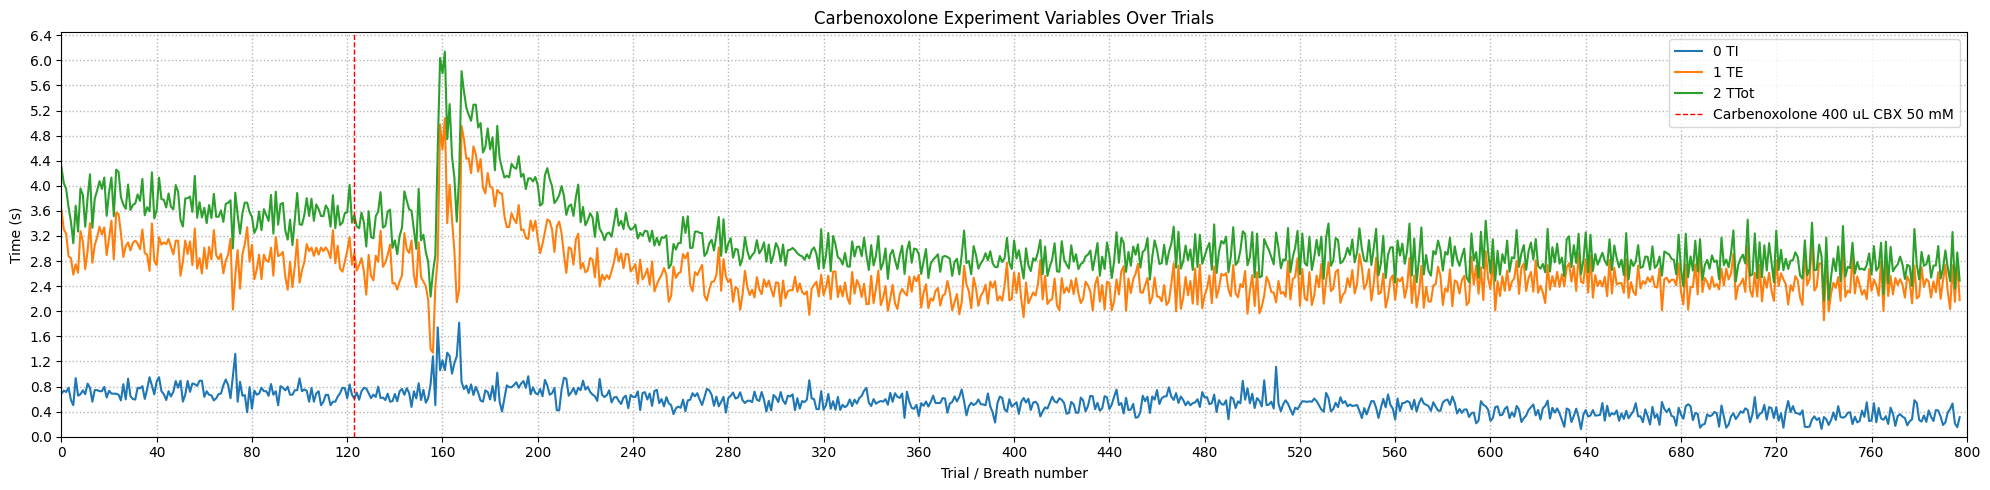

In [9]:
variables = ['0 TI', '1 TE', '2 TTot']
x = range(len(data)) #x axis range

plt.figure(figsize=(20, 5)) #figure size

for var in variables:
    plt.plot(x, data[var], label=var)

plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.9)  # style
plt.axvline(x=123, color='red', linestyle='--', linewidth=1, label='Carbenoxolone 400 uL CBX 50 mM')  #vertical line at breath 123 for the drug administration
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.yaxis.set_major_locator(plt.MaxNLocator(20))
plt.xlim([0,800]) # set x-axis limit    
plt.ylim(0, max(data[variables].max())*1.05)  # set y-axis limit
plt.xlabel('Trial / Breath number')
plt.ylabel('Time (s)')  # all variables are in seconds
plt.title('Carbenoxolone Experiment Variables Over Trials')
plt.legend()
plt.tight_layout()

plt.show()